In [2]:
import boto3
import time
import json
import csv
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import nxpd
from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError

from src.data_reader import DataReader, RetractionFinder
from src.to_gexf import to_gexf
from src.get_redacted import get_paper, load_redacted, get_doi, gen_retracted
from src.cleanup import DataCleaner
from src.network import Network, EdgeSplitter, PaperNLP, adj_matrix
import src.load_data as load_data

import pyspark
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql import dataframe
# import graphframes

import requests


In [3]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import log_loss, roc_curve, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [16]:
client = MongoClient()
db = client['capstone']
papers = db.papers
s3 = boto3.client('s3')

In [17]:
nodes_df = pd.read_csv('data/nodes', sep='|', header=None)
nodes_df.columns = ['id','year','authors']
edges_df = pd.read_csv('data/edges', sep='|', header=None)
edges_df.columns = ['source','target','year']
edges_df['id'] = edges_df.index

In [18]:
component = pd.read_json('data/component', lines=-1)

In [19]:
topics = set()
component['entities'].apply(lambda x: topics.update(set(x)))
print(f'Num. unique topics: {len(topics)}')
print(f'Num. topic labels: {sum(component["entities"].apply(len))}')

Num. unique topics: 12185
Num. topic labels: 93665


----

In [ ]:
# X0,Xt = train_test_split(component.loc[:, ['_id','paperAbstract','title','venue', 'inCitations', 'outCitations']])
X = component.loc[:, ['_id','paperAbstract','title','venue', 'inCitations', 'outCitations', 'entities']]



In [ ]:
abstract_tfidf = TfidfVectorizer()
abstract_tfidf.fit(X['paperAbstract'].apply(lambda x: x.lower().replace('withdraw', '').replace('retract', '')))
abstracts = abstract_tfidf.transform(X['paperAbstract'])


In [ ]:
title_tfidf = TfidfVectorizer()
title_tfidf.fit(X['title'].apply(lambda x: x.lower().replace('withdraw', '').replace('retract', '')))
titles = title_tfidf.transform(X['title'])


In [ ]:
topic_tfidf = TfidfVectorizer()
topic_tfidf.fit(X['entities'].apply(lambda x: ' '.join(x)))
topics = topic_tfidf.transform(X['entities'].apply(lambda x: ' '.join(x)))


In [ ]:
title_similarity = pd.DataFrame(cosine_similarity(titles), 
                                  columns=nodes_df['id'].values, 
                                  index=nodes_df['id'].values)
abstract_similarity = pd.DataFrame(cosine_similarity(abstracts),
                                     columns=nodes_df['id'].values, 
                                      index=nodes_df['id'].values)

topic_similarity = pd.DataFrame(cosine_similarity(topics),
                                     columns=nodes_df['id'].values, 
                                     index=nodes_df['id'].values)

-----

In [13]:
nodes_set = set(nodes_df['id'].values)
mask = np.array([itm in nodes_set for itm in edges_df['source']]) * \
       np.array([itm in nodes_set for itm in edges_df['target']])

g = nx.Graph(edges_df[mask].loc[:, ['source', 'target']])
adj = nx.adj_matrix(g, nodelist=nodes_df['id'].values)

KeyError: 'source'

In [13]:
adj_df = pd.DataFrame(adj.toarray())
adj_df.index = nodes_df['id'].values
adj_df.columns = nodes_df['id'].values

--------

In [14]:
print(abstract_similarity.values[adj_df.values.astype(bool)].mean())
print(abstract_similarity.values[~adj_df.values.astype(bool) & (abstract_similarity != 1)].mean())

0.17030471586631943
0.06605526655330404


In [15]:
print(title_similarity.values[adj_df.values.astype(bool)].mean())
print(title_similarity.values[~adj_df.values.astype(bool) & (title_similarity != 1)].mean())

0.09417847701568288
0.019786770175264125


In [16]:
print(topic_similarity.values[adj_df.values.astype(bool)].mean())
print(topic_similarity.values[~adj_df.values.astype(bool)].mean())

0.14789167966836445
0.024250933901632236


-----

In [17]:
lst = []
for i in range(50000): 
    n1,n2 = sorted(np.random.choice(a=nodes_df['id'], size=(2)))
    if n1!=n2 and [n1,n2]: lst.append([n1, n2])
for n1, n2 in edges_df.iloc[:, :2].values:
    if n1 in nodes_set and n2 in nodes_set:
        lst.append(sorted([n1,n2]))

Z = pd.DataFrame(np.unique(lst,axis=0), columns=['node1', 'node2'])
Z['title_similarity'] = title_similarity.lookup(col_labels=Z['node1'], row_labels=Z['node2'])
Z['topic_similarity'] = topic_similarity.lookup(col_labels=Z['node1'], row_labels=Z['node2'])
Z['abstract_similarity'] = abstract_similarity.lookup(col_labels=Z['node1'], row_labels=Z['node2'])
y = adj_df.lookup(col_labels=Z['node1'], row_labels=Z['node2'])

In [18]:
gbc = GradientBoostingClassifier(n_estimators=1000, random_state=5476, max_features=2)
X0, Xt, y0, yt = train_test_split(Z.iloc[:, 2:], y, random_state=5476)
gbc.fit(X0, y0)
tpr, fpr, thr = roc_curve(y_score=gbc.predict_proba(Xt)[:,1], y_true=yt)

0.9118591331175725


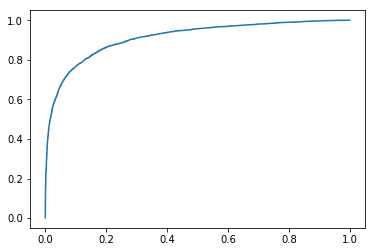

In [19]:
print(roc_auc_score(y_score=gbc.predict_proba(Xt)[:,1], y_true=yt))
plt.plot(tpr,fpr)


In [20]:
len(np.unique(lst,axis=0))/len(lst)
len(np.unique(lst))/len(lst)

0.08521851072103845

In [21]:
X = pd.DataFrame(np.random.choice(a=nodes_df['id'], size=(5000, 2), replace=True))
X.columns = ['node_1', 'node_2']
y = adj_df.lookup(col_labels=X['node_1'], row_labels=X['node_2'])


In [ ]:
%pdb
authors = Network.create_authors_dataframe(component, papers)

In [ ]:
(lambda x: [z['ids'][0] for y in x for z in y['authors'] if z['ids']])(papers.find({'_id': {'$in': ['d8asdf933097c2']}}))

In [ ]:
'<pymongo.cursor.Cursor object at 0x1a3b88aba8>'

In [ ]:
authors

In [ ]:
component

In [ ]:
network = Network()

In [113]:
from src.network import PaperNLP

In [ ]:
nlp = PaperNLP()
nlp.fit(component)
nlp.transform(X)

In [ ]:
X

In [47]:
def pd_to_gexf(edges, nodes, path, node_attr={}, edge_attr={}, dynamic=True):
    """
    Export two pandas frames to a single .gexf file for use in Gephi.
    ============
    Takes:
        edges: DataFrame object containing edges to export
        nodes: DataFrame object containing nodes to export
        path: string-location to save file
        attributes: keyword parameters corresponding to attribute names
    ============
    Returns: None
    """
    _nodes = ''#.join(nodes.T.apply(lambda v: f'      <node id="{v["id"]}"  start="{v["year"]}" end="2018" />\n'))
    _edges = ''#.join(edges.T.apply(lambda e: f'      <edge id="{e["id"]}" source="{e["src"]}" target="{e["dst"]}" start="{e["year"]}" end="2018" />\n'))
    _node_attributes = ''
    _edge_attributes = ''
    for i, (attribute, type_) in enumerate(node_attr.items()):
        _node_attributes += f'      <attribute id="{i}" title="{attribute}" type="{type_}"/>\n'
    for i, (attribute, type_) in enumerate(edge_attr.items()):
        _edge_attributes += f'      <attribute id="{i}" title="{attribute}" type="{type_}"/>\n'
    for _, n in nodes.iterrows():
        _nodes += f'      <node id="{n["id"]}"  start="{n["year"]}" end="2018"'
        for attr in node_attr:
            _nodes += f' {attr}="{n[attr]}"'
        _nodes += '/>\n'
    for _, e in edges.iterrows():
        _edges += f'      <edge id="{e["id"]}" source="{e["src"]}" target="{e["dst"]}" start="{e["year"]}" end="2018"'
        for attr in edge_attr:
            _edges += f' {attr}="{n[attr]}"'
        _edges += ' />\n'
    string =f"""<?xml version="1.0" encoding="UTF-8"?>
    <gexf xmlns="http://www.gexf.net/1.2draft" version="1.2" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.w3.org/2001/XMLSchema-instance">
      <graph mode="{'static' if not dynamic else 'dynamic'}" defaultedgetype="directed" name="">
        <attributes class="node">
  {_node_attributes}
        </attributes>        
        <nodes>
  {_nodes}
        </nodes>
        <attributes class="edge">
  {_edge_attributes}
        </attributes>     
        <edges>
  {_edges}
        </edges>
      </graph>
    </gexf>"""
    with open(path, 'w') as f:
        f.write(string)

In [56]:
def pd_to_gexf(edges, nodes, path, node_attr={}, edge_attr={}, dynamic=True):
    """
    Export two pandas frames to a single .gexf file for use in Gephi.
    ============
    Takes:
        edges: DataFrame object containing edges to export
        nodes: DataFrame object containing nodes to export
        path: string-location to save file
        attributes: keyword parameters corresponding to attribute names
    ============
    Returns: None
    """
    _nodes = ''#.join(nodes.T.apply(lambda v: f'      <node id="{v["id"]}"  start="{v["year"]}" end="2018" />\n'))
    _edges = ''#.join(edges.T.apply(lambda e: f'      <edge id="{e["id"]}" source="{e["src"]}" target="{e["dst"]}" start="{e["year"]}" end="2018" />\n'))
    _node_attributes = ''
    _edge_attributes = ''
    for i, (attribute, type_) in enumerate(node_attr.items()):
        _node_attributes += f'      <attribute id="{i}" title="{attribute}" type="{type_}"/>\n'
    for i, (attribute, type_) in enumerate(edge_attr.items()):
        _edge_attributes += f'      <attribute id="{i}" title="{attribute}" type="{type_}"/>\n'
    for _, n in nodes.iterrows():
        _nodes += f'      <node id="{n["id"]}"  start="{n["year"]}" end="2018">\n'
        _nodes += f'        <attvalues>\n'
        for i, attr in enumerate(node_attr):
            _nodes += f'          <attvalue for="{i}" value="{n[attr]}"/>\n'
        _nodes += f'        </attvalues>\n'
        _nodes += '      </node>\n'
    for _, e in edges.iterrows():
        _edges += f'      <edge id="{e["id"]}" source="{e["src"]}" target="{e["dst"]}" start="{e["year"]}" end="2018"'
        for attr in edge_attr:
            _edges += f' {attr}="{n[attr]}"'
        _edges += ' />\n'
    string =f"""<?xml version="1.0" encoding="UTF-8"?>
    <gexf xmlns="http://www.gexf.net/1.2draft" version="1.2" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.w3.org/2001/XMLSchema-instance">
      <graph mode="{'static' if not dynamic else 'dynamic'}" defaultedgetype="directed" name="">
        <attributes class="node">
  {_node_attributes}
        </attributes>        
        <nodes>
  {_nodes}
        </nodes>
        <attributes class="edge">
  {_edge_attributes}
        </attributes>     
        <edges>
  {_edges}
        </edges>
      </graph>
    </gexf>"""
    with open(path, 'w') as f:
        f.write(string)

In [57]:
%pdb
pd_to_gexf(edges_df, nodes_df, 'test.gexf', {'year':'float'}, {'year':'float'})

Automatic pdb calling has been turned OFF


In [ ]:
for _, row in nodes_df.iterrows():
    print(row['year'])
    break

In [20]:
edges_df.columns = ['src', 'dst', 'year', 'id']

-----

In [1]:
from src.network import EdgeSplitter

In [126]:
fields = ['entities', 'paperAbstract', 'title']
nlp = PaperNLP(*fields)
X0, Xt = train_test_split(component)
nlp.fit(X0)
E0 = split_edges(edges_df, X0).append(random_edges(X0))
Et = split_edges(edges_df, Xt).append(random_edges(Xt))
S0 = nlp.similarity_matrix(X0)
St = nlp.similarity_matrix(Xt)
y0,yt = E0['edge'], Et['edge']
for E in E0,Et: E.drop(['edge', '_id'], axis=1, inplace=True)
for field in fields:
    E0[field + '_similarity'] = S0[field].lookup(col_labels=E0['src'], row_labels=E0['dst'])
    Et[field + '_similarity'] = St[field].lookup(col_labels=Et['src'], row_labels=Et['dst'])

In [10]:
fields = ['entities', 'paperAbstract', 'title']
splitter = EdgeSplitter()
nlp = PaperNLP(*fields)
X0,E0,Xt,Et = splitter.split(component, edges_df)
nlp.fit(X0)
S0,St = [nlp.similarity_matrix(X) for X in (X0,Xt)]
y0,yt = E0['edge'], Et['edge']
for field in fields:
    E0[field + '_similarity'] = S0[field].lookup(col_labels=E0['src'], row_labels=E0['dst'])
    Et[field + '_similarity'] = St[field].lookup(col_labels=Et['src'], row_labels=Et['dst'])

gbc = GradientBoostingClassifier(n_estimators=1000, random_state=5476, max_features=2)
gbc.fit(E0.loc[:, [f + '_similarity' for f in fields]], y0.astype(int))

tpr, fpr, thr = roc_curve(y_score=gbc.predict_proba(
    Et.loc[:, [f + '_similarity' for f in fields]])[:,1], 
                          y_true=yt.astype(int))
print(roc_auc_score(y_score=gbc.predict_proba(
    Et.loc[:, [f + '_similarity' for f in fields]])[:,1],
      y_true=yt.astype(int)))
plt.plot(tpr,fpr)


In [11]:
gbc = GradientBoostingClassifier(n_estimators=1000, random_state=5476, max_features=2)
gbc.fit(E0.loc[:, [f + '_similarity' for f in fields]], y0.astype(int))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=2, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=5476, subsample=1.0, verbose=0,
              warm_start=False)

0.9182762375812801


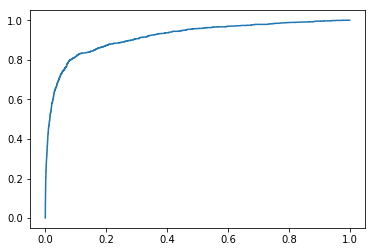

In [12]:
tpr, fpr, thr = roc_curve(y_score=gbc.predict_proba(
    Et.loc[:, [f + '_similarity' for f in fields]])[:,1], 
                          y_true=yt.astype(int))
print(roc_auc_score(y_score=gbc.predict_proba(
    Et.loc[:, [f + '_similarity' for f in fields]])[:,1],
      y_true=yt.astype(int)))
plt.plot(tpr,fpr)


0.9199364564215332


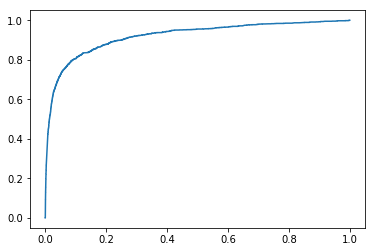

In [ ]:
#  ent0 = nlp.transform(X0)['entities']
# entt = nlp.transform(Xt)['entities']
# E0.T.apply(lambda x: cosine_similarity(X=ent0.loc[x[0]].values.reshape(1,-1), Y=ent0.loc[x[1]].values.reshape(1,-1)))

In [109]:
# E0.T.apply(lambda x: ent0.loc[x[0]])

In [110]:
def split_edges(edges, nodes):
    lst = []
    nodes_set = set(nodes['_id'].values)
    for src, dst in edges.loc[:, ['src','dst']].values:
        if src in nodes_set and dst in nodes_set:
            lst.append((src,dst, 1))
    return pd.DataFrame(lst,  columns=['src','dst','edge'])

def random_edges(X, n=50000):
    lst = []
    for i in range(n): 
        n1,n2 = sorted(np.random.choice(a=X['_id'], size=(2)))
        if n1!=n2 and [n1,n2]: lst.append([n1, n2,0])
    Z = pd.DataFrame(np.unique(lst,axis=0), columns=['src', 'dst', 'edge'])
    return Z

In [44]:
adj_matrix(edges_df, component, source_col='src', target_col='dst')

,001bb8dc34f15dbedb9a1280005f3bc6a345f98f,001f6a0ed6b775c4252cd5d08e9066b16cfed311,0020935272e8028eefdb8b9b92a5e24025dcab23,002332eac7bfb1ea70678a7d54173f721c4709b3,002d414d464aa7c76bf54f18a36da6f70a73de9c,002f10c89dc45b04ba2e53174b0292e9cf386f3e,0030a4674088aaec66524b64e92f33dd7484a1aa,0033464a0d258dd832de2ce39d5c546093b68009,00350c09cbeff2ad2ae80705109247358c142e39,003760230927ca8f1404dbfa1dba41331126a508,...,ff953efaa67fdb318505cf246ed77e777d11ff2e,ff98ac4a59176d76db754e1f7f3a743ade21059a,ff9f052c786a3e7a6af5f4e26dd78bf94630dd4f,ffaf4494ab43737e9f7facb5499fe1740aabef8e,ffb143cfd5287845d4206f8bd110a1036bd3d408,ffb51f74cf42ba91931d67ffee8a1c3e8dcb19a0,ffb63d03be0b212c6e5803d0f1aae20c5f6c244d,ffbbf95710da72fa9c065f45bc619cfff11f7b39,ffd0608ddb97cfdc4706ca3fc29b8b72a72173fa,fff8b164394233bd93cea878287348453be6e506
001bb8dc34f15dbedb9a1280005f3bc6a345f98f,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
001f6a0ed6b775c4252cd5d08e9066b16cfed311,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0020935272e8028eefdb8b9b92a5e24025dcab23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
002332eac7bfb1ea70678a7d54173f721c4709b3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
002d414d464aa7c76bf54f18a36da6f70a73de9c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
002f10c89dc45b04ba2e53174b0292e9cf386f3e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0030a4674088aaec66524b64e92f33dd7484a1aa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0033464a0d258dd832de2ce39d5c546093b68009,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00350c09cbeff2ad2ae80705109247358c142e39,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
003760230927ca8f1404dbfa1dba41331126a508,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [104]:
title_similarity = pd.DataFrame(cosine_similarity(ent0), 
                                  columns=X0['_id'].values, 
                                  index=X0['_id'].values)

In [105]:
title_similarity()

TypeError: 'DataFrame' object is not callable

In [40]:
randE = random_edges(Xt)

In [26]:
#     Z['title_similarity'] = title_similarity.lookup(col_labels=Z['node1'], row_labels=Z['node2'])
#     Z['topic_similarity'] = topic_similarity.lookup(col_labels=Z['node1'], row_labels=Z['node2'])
#     Z['abstract_similarity'] = abstract_similarity.lookup(col_labels=Z['node1'], row_labels=Z['node2'])
#     y = adj_df.lookup(col_labels=Z['node1'], row_labels=Z['node2'])

In [35]:
np.unique(['1','2'])

array(['1', '2'], dtype='<U1')